# Cortical transform in this repo compared to nsltools

This notebook:
- checks that the rate and scale filters are the same as in nsltools matlab
- replicates nsltools matlab forward and backward cortical in the fft domain
- shows cortical forward in time domain

TODO:
- cortical forward with tensorflow

In [1]:
from collections import namedtuple
import itertools
import glob
import logging
import os
import random


import argparse
import numpy as np
import pydub
import tensorflow as tf

# from audio_load import load_audio_from_files, audio2spec
from st_2d import scat2d
import windows as win

In [2]:
save_path = '/scratch0/ilya/locDownloads/advaudio_fig/'

In [3]:
from PIL import Image

In [4]:
import imageio

In [5]:
import importlib

In [6]:
importlib.reload(win)

<module 'windows' from '/cfarhomes/ilyak/ilyakavalerov@gmail.com/ramawks69/pyfst/windows.py'>

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as ipd
import librosa.display

In [8]:
# cortical
rv = [4, 8, 16, 32]
sv = [.25, .5, 1, 2, 4, 8]

# winobj = win.cortical_psi_factory(rv, sv, 128)
# print(winobj.nfilt)

In [9]:
from colorsys import hls_to_rgb

def make_color(M):
    return (M - M.min()) / (M.max() - M.min())

def colorize(z):
    # complex to color
    # https://stackoverflow.com/questions/17044052/mathplotlib-imshow-complex-2d-array/36082859
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + np.pi)  / (2 * np.pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    return c

In [10]:
def SI_SDR(y, yhat, axes=(0,)):
    """Scale invariant sdr
    """
    scaling = (np.abs(y) / np.abs(yhat)).mean(axis=axes, keepdims=True)
#     print(scaling)
    diff = (y - scaling*yhat)
    return 10*np.log10(( diff*np.conj(diff) ).sum() / ( y*np.conj(y) ).sum())

def SDR(y, yhat, axes=(0,)):
    """sdr
    """
    diff = (y - yhat)
    return 10*np.log10(( diff*np.conj(diff) ).sum() / ( y*np.conj(y) ).sum())

## Load data

This data was saved from nsltools matlab to verify python implementations against the original matlab. Download it [here](https://github.com/ilyakava/nsltools_matlab_mirror).

In [11]:
import scipy.io as sio

In [12]:
from librosa.filters import mel

In [13]:
mat_data_path = '/cfarhomes/ilyak/ilyakavalerov@gmail.com/ramawks69/nsltools'

In [14]:
mat_contents = sio.loadmat(os.path.join(mat_data_path, 'x_audio_8kHz.mat'))
y = mat_contents['x'].squeeze()
len(y)

8181

In [15]:
mat_contents = sio.loadmat(os.path.join(mat_data_path, 'y_audspec_8kHz.mat'))
audspec_nsl = mat_contents['y'].squeeze()

In [16]:
mat_contents = sio.loadmat(os.path.join(mat_data_path, 'Y_audspec_fft_8kHz.mat'))
audspec_ft = mat_contents['Y'].squeeze()

In [17]:
mat_contents = sio.loadmat(os.path.join(mat_data_path, 'z_cort_8kHz.mat'))
cort_nsl = mat_contents['z'].squeeze()

In [18]:
mat_contents = sio.loadmat(os.path.join(mat_data_path, 'Z-cum_inverse_8kHz.mat'))
Z_cum_nsl = mat_contents['Z_cum'].squeeze()

In [19]:
mat_contents = sio.loadmat(os.path.join(mat_data_path, 'HH-cum_inverse_8kHz.mat'))
HH_cum_nsl = mat_contents['HH'].squeeze()

In [20]:
mat_contents = sio.loadmat(os.path.join(mat_data_path, 'yh_rec_audspec_8kHz.mat'))
audspec_est_nsl = mat_contents['yh'].squeeze()

Even the official reconstruction of the auditory spectrogram is not perfect

In [21]:
SDR(np.abs(audspec_nsl), np.abs(audspec_est_nsl))

-7.155961220250052

In [22]:
audspec_whitened = (audspec_nsl - audspec_nsl.mean()) / audspec_nsl.var()
audspec_est_whitened = (audspec_est_nsl - audspec_est_nsl.mean()) / audspec_est_nsl.var()

In [23]:
SDR(np.abs(audspec_whitened), np.abs(audspec_est_whitened))

-6.667061487420023

In [24]:
cort_nsl.shape

(6, 8, 128, 128)

In [25]:
ipd.Audio(y, rate=8000)

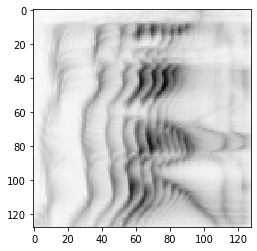

In [26]:
plt.imshow(audspec_nsl**0.3, cmap='Greys') #lowest freq on bottom

By the way, this is different than LFBE

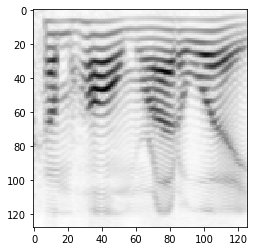

In [27]:
spec = np.abs(librosa.core.stft(y,
        win_length=400,
        hop_length=65,
        n_fft=512))
A = mel(8000, 512, n_mels=128)
lfbe = np.dot(A,spec)
plt.imshow(lfbe**0.3, cmap='Greys')

## Check the filters

In [28]:
from windows import FilterType, gen_cort, gen_corf

(-312.4882696052125+0j)
(-311.0034244291803+0j)
(-309.497675985582+0j)
(-298.6589436358962+0j)


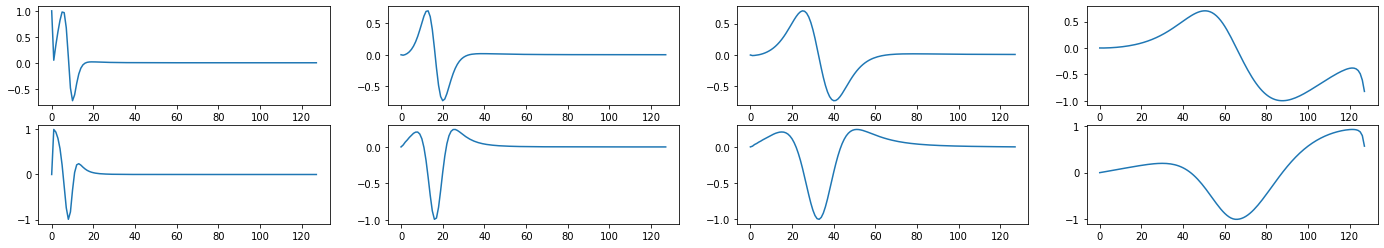

In [29]:
f, axes = plt.subplots(2, len(rv), figsize=(24,4))
for rdx, rate in enumerate(rv):
    ratef_type = FilterType.BANDPASS
    if rdx == 0:
        ratef_type = FilterType.LOWPASS
    elif rdx == (len(rv) - 1):
        ratef_type = FilterType.HIGHPASS
        
    f_py = gen_cort(rate, 128, filt_type=ratef_type)
    mat_contents = sio.loadmat(os.path.join(mat_data_path, 'HR_FD_rdx_{}_sgn_1.mat'.format(rdx+1)))
    f_mat = mat_contents['HR'].squeeze()
    f_mat = f_mat[:128]
    print(SDR(f_mat, f_py))
    axes[0,rdx].plot(np.real(f_py))
    axes[1,rdx].plot(np.imag(f_py))

-305.7720777177428
-452.1636510690728
-328.75800279683125
-322.59579120013984
-322.3908582018757
-308.36132211956044


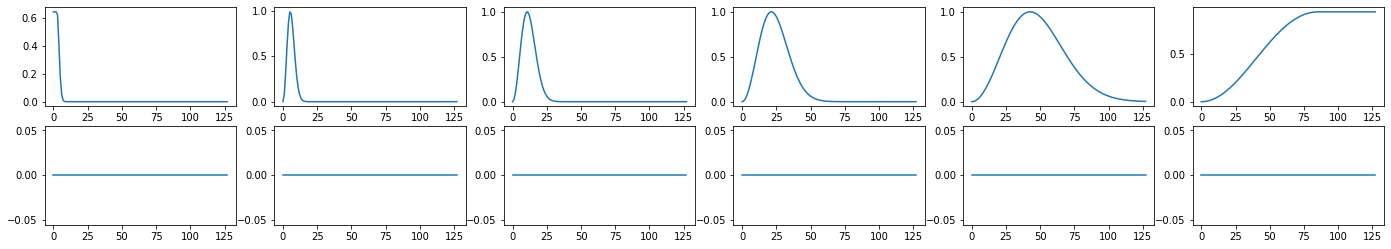

In [30]:
f, axes = plt.subplots(2, len(sv), figsize=(24,4))

for sdx, scale in enumerate(sv):
    scalef_type = FilterType.BANDPASS
    if sdx == 0:
        scalef_type = FilterType.LOWPASS
    elif sdx == (len(sv) - 1):
        scalef_type = FilterType.HIGHPASS

    f_py = gen_corf(scale, 128, filt_type=scalef_type)
    mat_contents = sio.loadmat(os.path.join(mat_data_path, 'HS_FD_rdx_{}.mat'.format(sdx+1)))
    f_mat = mat_contents['HS'].squeeze()
    f_mat = f_mat[:128]
    print(SDR(f_mat, f_py))
    
    axes[0,sdx].plot(np.real(f_py))
    axes[1,sdx].plot(np.imag(f_py))

In [31]:
def cortical_2x1d_FDomain_factory(rv, sv, l):
    """
    in schematc nsltools uses params:
    [4, 8, 16, 32], [.25, .5, 1, 2, 4, 8], 128
    """
    filters = np.zeros((len(sv),len(rv),2,l), dtype=np.complex64)
    for rdx, rate in enumerate(rv):
        for sdx, scale in enumerate(sv):

            rate_filt_type = FilterType.BANDPASS
            if rate == min(rv):
                rate_filt_type = FilterType.LOWPASS
            elif rate == max(rv):
                rate_filt_type = FilterType.HIGHPASS
            scale_filt_type = FilterType.BANDPASS
            if scale == min(sv):
                scale_filt_type = FilterType.LOWPASS
            elif scale == max(sv):
                scale_filt_type = FilterType.HIGHPASS

            R1 = gen_cort(rate, l, filt_type=rate_filt_type)
            R2 = gen_corf(scale, l, filt_type=scale_filt_type)

            filters[sdx,rdx,0,:] = R1
            filters[sdx,rdx,1,:] = R2
    return filters

In [32]:
l = 128
cfs = cortical_2x1d_FDomain_factory([4, 8, 16, 32], [.25, .5, 1, 2, 4, 8], l)

## CPU Fourier Domain in 2 steps

In [33]:
import scipy

In [34]:
mat_contents = sio.loadmat(os.path.join(mat_data_path, 'z1_TD_rdx_1_sgn_1.mat'))
z1 = mat_contents['z1'].squeeze()

In [35]:
R1 = gen_cort(4, l, filt_type=FilterType.LOWPASS)
R1 = np.pad(R1, (0,l))
R1 = np.expand_dims(R1, -1)
cort_0_0 = audspec_ft * R1

z1_py = scipy.fft.ifft(cort_0_0, 256, 0)
z1_py = z1_py[:128,:]

SI_SDR(z1, z1_py)

(-97.83364001508556+0j)

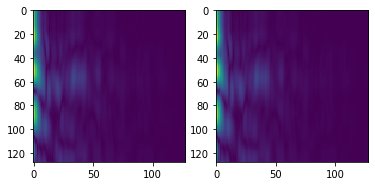

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(z1_py))
ax2.imshow( np.abs(z1))


In [37]:
R2 = gen_corf(0.25, l, filt_type=FilterType.LOWPASS)
R2 = np.expand_dims(R2, 0)
cort_0_0 = z1_py * R2

cort_0_0 = scipy.fft.ifft(cort_0_0, 256, 1)
cort_0_0 = cort_0_0[:,:128]
cort_ref = cort_nsl[0,4,:,:]

SI_SDR(cort_ref, cort_0_0)

(-108.8404154510109+0j)

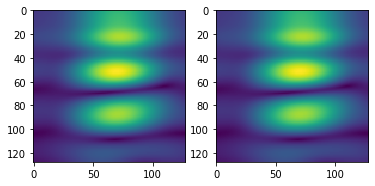

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(cort_0_0[:128,:128]))
ax2.imshow( np.abs(cort_nsl[0,4,:,:]))


## CPU Fourier Domain in 1 step

In [39]:
R1 = gen_cort(4, l, filt_type=FilterType.LOWPASS)
R1 = np.pad(R1, (0,l))
R1 = np.expand_dims(R1, -1)
cort_0_0 = audspec_ft * R1

R2 = gen_corf(0.25, l, filt_type=FilterType.LOWPASS)
R2 = np.expand_dims(R2, 0)
cort_0_0 = cort_0_0 * R2

cort_0_0 = scipy.fft.ifft2(cort_0_0, (256,256))
cort_0_0 = cort_0_0[:128,:128]


In [40]:
cort_ref = cort_nsl[0,4,:,:]

SI_SDR(cort_ref, cort_0_0)

(-108.84041545102738+0j)

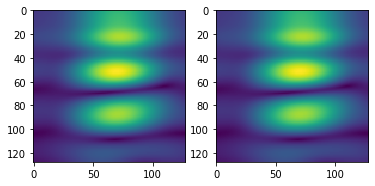

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(cort_0_0[:128,:128]))
ax2.imshow( np.abs(cort_nsl[0,4,:,:]))

In [42]:
def fft_forward_cortical(cfs, input_fft):
    """fft forward cortical
    
    python implementation of aud2cor in nsltools matlab
    """
    l = cfs.shape[3]
    cort_py_fft = np.zeros((cfs.shape[0], 2*cfs.shape[1], l, l), dtype=np.complex)
    for sdx in range(cfs.shape[0]):
        for rdx in range(cfs.shape[1]):
            for sign in [1,-1]:
                R1 = cfs[sdx,rdx,0]
                R2 = cfs[sdx,rdx,1]

                if sign == 1:
                    R1 = np.pad(R1, (0,l))
                else:
                    R1 = np.pad(R1, (0,l))
                    R1 = [R1[0]] + list(np.conj(R1[1:])[::-1])
                    R1[l] = np.abs(R1[l+1])
                    R1 = np.array(R1)

                R1 = np.expand_dims(R1, -1)
                cort_0_0 = input_fft * R1

                R2 = np.expand_dims(R2, 0)
                cort_0_0 = cort_0_0 * R2

                cort_0_0 = scipy.fft.ifft2(cort_0_0, (2*l,2*l))
                
                cort_0_0 = cort_0_0[:l,:l]

                cort_py_fft[sdx,rdx + int(sign==1)*cfs.shape[1]] = cort_0_0
    return cort_py_fft

In [43]:
cort_py_fft = fft_forward_cortical(cfs, audspec_ft)

In [44]:
SI_SDR(cort_nsl, cort_py_fft, (2,3))

(-94.39842016849059+0j)

## Interchange between two domains

In [45]:
fd_est = scipy.fft.fft2(audspec_nsl, (256,256))
fd_est = fd_est[:,:128]

SI_SDR(audspec_ft, fd_est, axes=(0,1))

(-98.75414010161211+0j)

In [46]:
td_est = scipy.fft.ifft2(audspec_ft, (256,256))
td_est = td_est[:128,:128]

SI_SDR(audspec_nsl, td_est, axes=(0,1))

(-3.5044051158212324+0j)

## CPU time domain, truncation after convolution

In [47]:
R1 = gen_cort(4, l, filt_type=FilterType.LOWPASS)
R1 = np.pad(R1, (0,l))
# R1 = np.expand_dims(R1, -1)

a = scipy.fft.ifft(audspec_ft, 256, 0)#[:128,:]
b = scipy.fft.ifft(R1, 256, 0)#[:128]
b = np.expand_dims(b,-1)
# cort_0_0 = audspec_ft * R1

# z1_py = scipy.fft.ifft(cort_0_0, 256, 0)
z1_py  = scipy.signal.convolve(a, np.roll(b,l), mode='same')

z1_py = z1_py[:128,:]

SI_SDR(z1, z1_py)

(-19.174294334900587+0j)

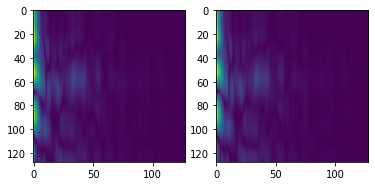

In [48]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(z1_py)) 
ax2.imshow( np.abs(z1))


In [49]:
R2 = gen_corf(0.25, l, filt_type=FilterType.LOWPASS)
# R2 = np.expand_dims(R2, 0)

a = scipy.fft.ifft(z1_py, 256, 1)
b = scipy.fft.ifft(R2, 256)
b = np.expand_dims(b,0)
# cort_0_0 = z1_py * R2

cort_0_0  = scipy.signal.convolve(a, np.roll(b,l), mode='same')
# cort_0_0 = scipy.fft.ifft(cort_0_0, 256, 1)
cort_0_0 = cort_0_0[:,:128]


cort_ref = cort_nsl[0,4,:,:]

SI_SDR(cort_ref, cort_0_0)

(-16.858687675158826+0j)

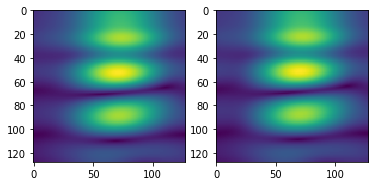

In [50]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(cort_0_0)) 
ax2.imshow( np.abs(cort_ref))


## CPU time domain, with truncation of input, but full conv

In [51]:
# with no truncation
R1 = gen_cort(4, l, filt_type=FilterType.LOWPASS)
R1 = np.pad(R1, (0,l))

a = scipy.fft.ifft(audspec_ft, 256, 0)[:128,:]
b = scipy.fft.ifft(R1, 256, 0)#[:128]
b = np.expand_dims(b,-1)
# cort_0_0 = audspec_ft * R1

# z1_py = scipy.fft.ifft(cort_0_0, 256, 0)
z1_py  = scipy.signal.convolve(a, np.roll(b,l), mode='same')

z1_py = z1_py[:128,:]

R2 = gen_corf(0.25, l, filt_type=FilterType.LOWPASS)
# R2 = np.expand_dims(R2, 0)

a = scipy.fft.ifft(z1_py, 256, 1)[:,:128]
b = scipy.fft.ifft(R2, 256)
b = np.expand_dims(b,0)
# cort_0_0 = z1_py * R2

cort_0_0  = scipy.signal.convolve(a, np.roll(b,l), mode='same')
# cort_0_0 = scipy.fft.ifft(cort_0_0, 256, 1)
cort_0_0 = cort_0_0[:,:128]


cort_ref = cort_nsl[0,4,:,:]

SI_SDR(cort_ref, cort_0_0)



(-15.408474892453723+0j)

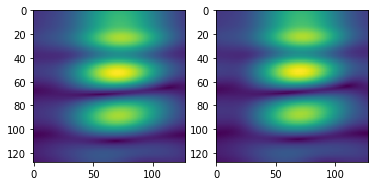

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(cort_0_0)) 
ax2.imshow( np.abs(cort_ref))


## CPU time domain, with input in time domain

In [53]:
l=128

In [54]:
# with no truncation
R1 = gen_cort(4, l, filt_type=FilterType.LOWPASS)
R1 = np.pad(R1, (0,l))

b = scipy.fft.ifft(R1, l*2, 0)#[:128]
b = np.expand_dims(b,-1)
# cort_0_0 = audspec_ft * R1

# z1_py = scipy.fft.ifft(cort_0_0, 256, 0)
z1t_py  = scipy.signal.convolve(audspec_nsl, np.roll(b,l), mode='same')

# z1t_py = z1_py[:128,:]

R2 = gen_corf(0.25, l, filt_type=FilterType.LOWPASS)
# R2 = np.expand_dims(R2, 0)

b = scipy.fft.ifft(R2, l*2)
b = np.expand_dims(b,0)
# cort_0_0 = z1_py * R2

cort_0_0  = scipy.signal.convolve(z1t_py, np.roll(b,l), mode='same')
# cort_0_0 = scipy.fft.ifft(cort_0_0, 256, 1)
# cort_0_0 = cort_0_0[:,:128]


cort_ref = cort_nsl[0,4,:,:]

SI_SDR(cort_ref, cort_0_0)

(-18.404016902741066+0j)

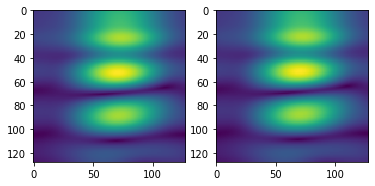

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(cort_0_0)) 
ax2.imshow( np.abs(cort_ref))


In [56]:
def forward_cortical(cfs, audspec):
    """forward cortical in time domain
    """
    l = cfs.shape[3]
    cort_py_fft = np.zeros((cfs.shape[0], 2*cfs.shape[1], audspec.shape[0], audspec.shape[1]), dtype=np.complex)
    for sdx in range(cfs.shape[0]):
        for rdx in range(cfs.shape[1]):
            for sign in [1,-1]:
                R1 = cfs[sdx,rdx,0]
                R2 = cfs[sdx,rdx,1]

                if sign == 1:
                    R1 = np.pad(R1, (0,l))
                else:
                    R1 = np.pad(R1, (0,l))
                    R1 = [R1[0]] + list(np.conj(R1[1:])[::-1])
                    R1[l] = np.abs(R1[l+1])
                    R1 = np.array(R1)

                r1 = scipy.fft.ifft(R1, l*2, 0)
                r1 = np.expand_dims(r1,-1)
                
                z1t_py  = scipy.signal.convolve(audspec, np.roll(r1,l), mode='same')

                r2 = scipy.fft.ifft(R2, l*2)
                r2 = np.expand_dims(r2,0)
                
                cort_0_0  = scipy.signal.convolve(z1t_py, np.roll(r2,l), mode='same')
                
                cort_py_fft[sdx,rdx + int(sign==1)*cfs.shape[1]] = cort_0_0
    return cort_py_fft

In [57]:
cort_py = forward_cortical(cfs, audspec_nsl)

In [58]:
SI_SDR(cort_nsl, cort_py, axes=(2,3))

(-2.991797079871252+0j)

In [59]:
SI_SDR(cort_nsl[3,4], cort_py[3,4])

(-3.077835300648633+0j)

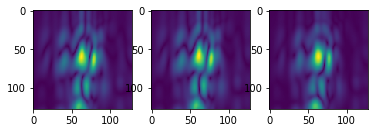

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(np.abs( cort_py[3,4])) 
ax2.imshow( np.abs(cort_nsl[3,4]))

scaling = (np.abs(cort_nsl[3,4]) / np.abs(cort_py[3,4])).mean(keepdims=True)
err = cort_py[3,4]-cort_nsl[3,4]*scaling
ax3.imshow( np.abs(err ))

dB SDR is not that low, but, the transform looks like it is doing the right thing.

## CPU time domain, with input in time domain, shorter filt

In [61]:
# with no truncation
R1 = gen_cort(4, l, filt_type=FilterType.LOWPASS)
R1 = np.pad(R1, (0,l))

b = scipy.fft.ifft(R1, l*2, 0)[:l]
b = np.expand_dims(b,-1)
# cort_0_0 = audspec_ft * R1

# z1_py = scipy.fft.ifft(cort_0_0, 256, 0)
z1t_py  = scipy.signal.convolve(audspec_nsl, np.roll(b,l//2), mode='same')

# z1t_py = z1_py[:128,:]

R2 = gen_corf(0.25, l, filt_type=FilterType.LOWPASS)
# R2 = np.expand_dims(R2, 0)

b = scipy.fft.ifft(R2, l)
b = np.expand_dims(b,0)
# cort_0_0 = z1_py * R2

cort_0_0  = scipy.signal.convolve(z1t_py, np.roll(b,l//2), mode='same')
# cort_0_0 = scipy.fft.ifft(cort_0_0, 256, 1)
# cort_0_0 = cort_0_0[:,:128]


cort_ref = cort_nsl[0,4,:,:]

SI_SDR(cort_ref, cort_0_0)

(-1.3544907999090419+0j)

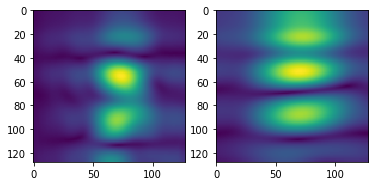

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(cort_0_0)) 
ax2.imshow( np.abs(cort_ref))


It is not OK to truncate the filter however

### Another one

In [63]:
l=128

In [64]:
# with no truncation
R1 = gen_cort(8, l, filt_type=FilterType.BANDPASS)
R1 = np.pad(R1, (0,l))

b = scipy.fft.ifft(R1, l*2, 0)[:l]
b = np.expand_dims(b,-1)
# cort_0_0 = audspec_ft * R1

# z1_py = scipy.fft.ifft(cort_0_0, 256, 0)
z1t_py  = scipy.signal.convolve(audspec_nsl, np.roll(b,l//2), mode='same')

# z1t_py = z1_py[:128,:]

R2 = gen_corf(0.5, l, filt_type=FilterType.BANDPASS)
# R2 = np.expand_dims(R2, 0)

b = scipy.fft.ifft(R2, 128)
b = np.expand_dims(b,0)
# cort_0_0 = z1_py * R2

cort_0_0  = scipy.signal.convolve(z1t_py, np.roll(b,l//2), mode='same')
# cort_0_0 = scipy.fft.ifft(cort_0_0, 256, 1)
# cort_0_0 = cort_0_0[:,:128]


cort_ref = cort_nsl[1,5,:,:]

SI_SDR(cort_ref, cort_0_0)

(6.156386207611503+0j)

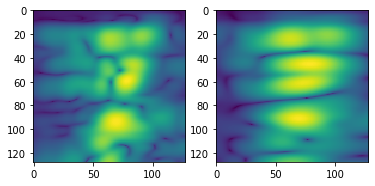

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(cort_0_0)**0.3) 
ax2.imshow( np.abs(cort_ref)**0.3)


Could have a choice, to get smaller filters either 1) use a smaller l, 2) truncate the fft

## Invert cortical

In [66]:
def fft_backward_cortical(cfs, input_cort):
    """fft backward cortical
    
    python version of cor2aud in nsltools matlab
    """
    NORM = 0.9
    l = cfs.shape[3]
    audspec_fft = np.zeros((2*l, l), dtype=np.complex)
    H_cum = np.zeros((l*2, l), dtype=np.complex)
    for rdx in range(cfs.shape[1]):
        for sign in [1,-1]:
            for sdx in range(cfs.shape[0]):
                z = input_cort[sdx,rdx + int(sign==1)*cfs.shape[1]]
                z = np.pad(z,((0,0),(0,l)))
                Z = scipy.fft.fft2(z, (2*l,2*l))
                Z = Z[:,:l]
                
                
                R1 = cfs[sdx,rdx,0]
                R2 = cfs[sdx,rdx,1]
                if sign == 1:
                    R1 = np.conj(np.pad(R1, (0,l)))
                else:
                    R1 = np.conj(np.pad(R1, (0,l)))
                    R1 = [R1[0]] + list(np.conj(R1[1:])[::-1])
                    R1[l] = np.abs(R1[l+1])
                    R1 = np.array(R1)
                
                R1 = np.expand_dims(R1,-1)
                R2 = np.expand_dims(R2,0)
                H = np.dot(R1, R2);
                
                H_cum += H * np.conj(H)
                audspec_fft += H * Z
    
#     return (audspec_fft, H_cum) # can check that these match the *mat files
    
    H_cum[:,0] *= 2
    sumH = H_cum.sum()
    H_cum = NORM * H_cum + (1 - NORM) * H_cum.max();
    H_cum = H_cum / H_cum.sum() * sumH;
    audspec_fft = audspec_fft / H_cum
    
    audspec = scipy.fft.ifft2(audspec_fft, (2*l,2*l))
    audspec = 2*audspec[:l,:l]
                
    return audspec



In [67]:
audspec_hat = fft_backward_cortical(cfs, cort_nsl)

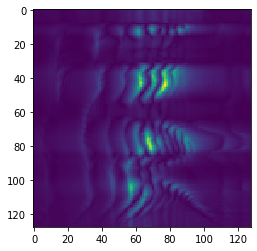

In [68]:
plt.imshow(np.abs(audspec_hat))

In [69]:
SI_SDR(audspec_est_nsl, audspec_hat ) 

(-60.80691490914377+0j)

Inversion is hapenning the same way as in the matlab code

In [70]:
SDR(audspec_nsl, audspec_hat ) 

(-1.6379657006021628+0j)

Seems like inversion is not super close though

## Cortical forward and backward, successfully reconstructs

In [71]:
fd_est = scipy.fft.fft2(audspec_nsl, (256,256))
fd_est = fd_est[:,:128]
cort_py = fft_forward_cortical(cfs, fd_est)
audspec_hat = fft_backward_cortical(cfs, cort_py)
SDR(np.abs(audspec_nsl), np.abs(audspec_hat) ) 

-7.156699069700205

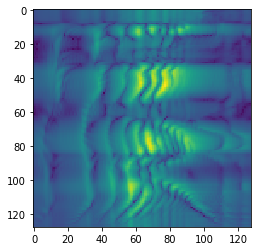

In [72]:
plt.imshow(np.abs(audspec_hat)**0.3)

In [73]:
cort_py = forward_cortical(cfs, audspec_nsl)
audspec_hat = fft_backward_cortical(cfs, cort_py)
SDR(np.abs(audspec_nsl), np.abs(audspec_hat) ) 

-5.237786306174813

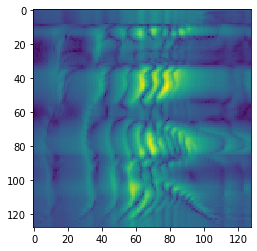

In [74]:
plt.imshow(np.abs(audspec_hat)**0.3)

## Plot the filters in time domain

In [75]:
cfs = cortical_2x1d_FDomain_factory([4, 8, 16, 32], [.25, .5, 1, 2, 4, 8], 64)

In [76]:
# iterate in cortical specific way
# 6 x 4, left and right

nrow = cfs.shape[0]
ncol = cfs.shape[1]
l = cfs.shape[3]

img = np.zeros((2+(2*l+2)*nrow, 2+((2*l+2)*(ncol*2)), 3))
for left_right in range(2):
    sign = -1**left_right
    for col in range(ncol):
        for row in range(nrow):
            sdx = row
            rdx = col
            R1 = cfs[sdx,rdx,0]
            R2 = cfs[sdx,rdx,1]

            if sign == 1:
                R1 = np.pad(R1, (0,l))
            else:
                R1 = np.pad(R1, (0,l))
                R1 = [R1[0]] + list(np.conj(R1[1:])[::-1])
                R1[l] = np.abs(R1[l+1])
                R1 = np.array(R1)

            r1 = np.roll(scipy.fft.ifft(R1, l*2, 0), l)
            r1 = np.expand_dims(r1,-1)

            r2 = np.roll(scipy.fft.ifft(R2, l*2), l)
            r2 = np.expand_dims(r2,0)
            
            filt_ = np.dot(r1, r2)
            
            idx = 2*row + col*12 + left_right # even is phase 1
            if left_right == 0:
                x = col
            else:
                x = col + left_right*4
            y = row
            
            
            tmp_img = colorize(filt_)
            for chan in range(tmp_img.shape[2]):
                tmp_img[:,:,chan] = (tmp_img[:,:,chan] - tmp_img[:,:,chan].mean()) / (3*tmp_img[:,:,chan].std())
                tmp_img[:,:,chan] /= 2.0
                tmp_img[:,:,chan] += 0.5
                tmp_img[:,:,chan] = np.clip(tmp_img[:,:,chan], 0, 1)
            img[ (y*(2*l+2)+2):((y+1)*(2*l+2)), (x*(2*l+2)+2):((x+1)*(2*l+2)) ] = \
                tmp_img
            


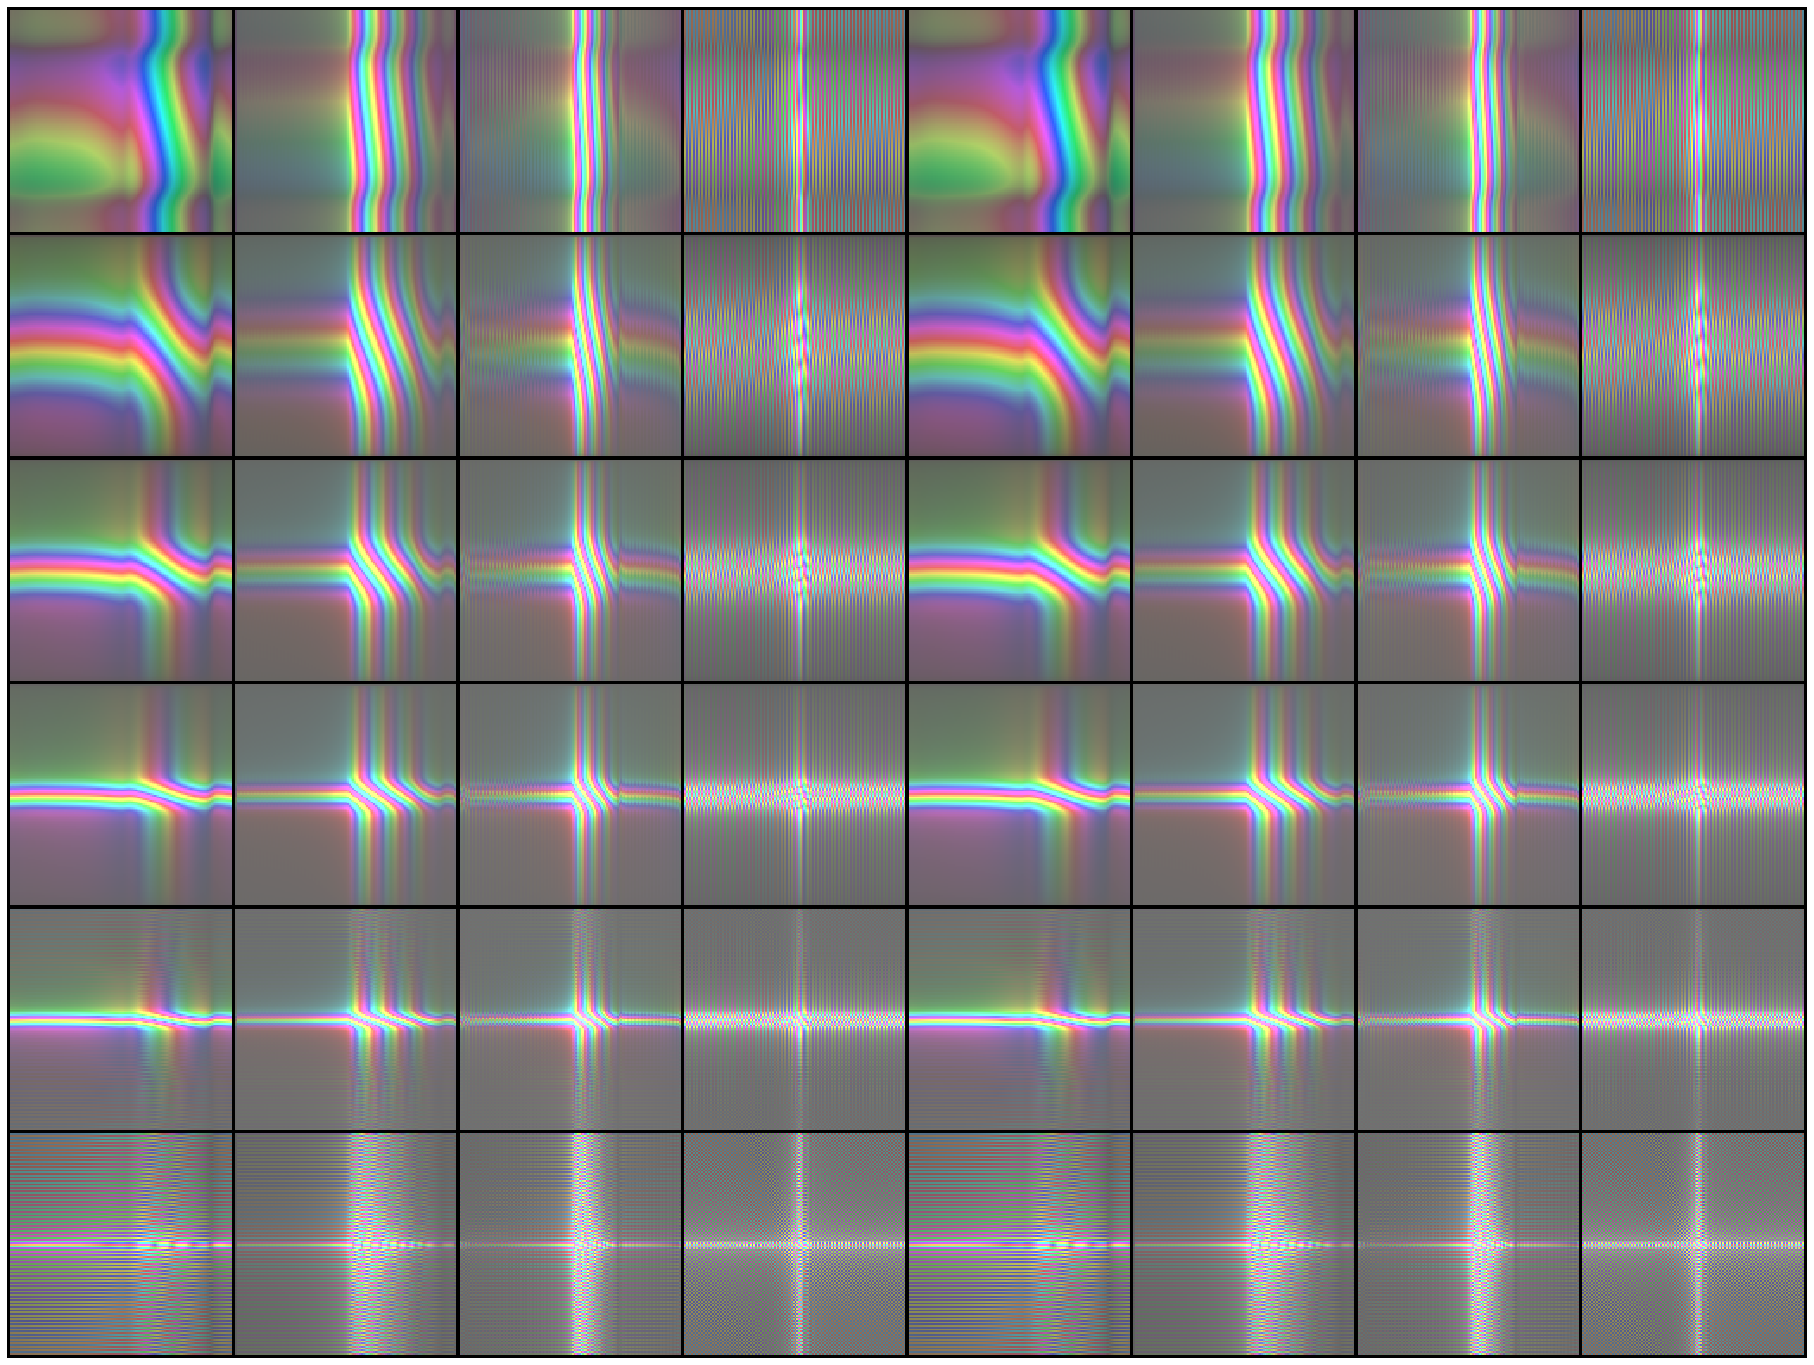

In [77]:
fig = plt.figure()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
fig.set_figheight(25)
fig.set_figwidth(25)
plt.imshow(img)
# plt.imshow(img[:,:,0], cmap='Greys')

## Listenable results

In [78]:
import nsltools as nslpy

In [79]:
importlib.reload(nslpy)

<module 'nsltools' from '/cfarhomes/ilyak/ilyakavalerov@gmail.com/ramawks69/pyfst/nsltools.py'>

In [80]:
mat_contents = sio.loadmat(os.path.join(mat_data_path, 'x_audio_8kHz.mat'))
y = mat_contents['x'].squeeze()

In [81]:
# params are: frame length * 2^(4+octave shift), decaying factor denominator, nonlinear factor, octave shift
# 8kHz: [8,8,-2,-1]
# 16kHz: one,two, three, 0
audspec_py = nslpy.wav2aud(y, [8,8,-2,-1])
wav0_py, wavmin_py, _  = nslpy.aud2wav(audspec_py, np.array([]), [8,8,-2,-1] + [10,0,1])



0, Err.: 85.89 (rel.) 1977.63 (abs.) Energy: 61.934457023774094
1, Err.: 21.93 (rel.) 40.7 (abs.) Energy: 82.08311306489063
2, Err.: 15.25 (rel.) 31.36 (abs.) Energy: 83.41065305472169
3, Err.: 12.36 (rel.) 29.32 (abs.) Energy: 84.77083082257468
4, Err.: 10.5 (rel.) 27.81 (abs.) Energy: 85.46972893480493
5, Err.: 9.18 (rel.) 26.8 (abs.) Energy: 85.91852506294435
6, Err.: 8.17 (rel.) 26.06 (abs.) Energy: 86.13652883321981
7, Err.: 7.37 (rel.) 25.54 (abs.) Energy: 86.28420914308552
8, Err.: 6.77 (rel.) 25.12 (abs.) Energy: 86.63068443246897
9, Err.: 6.31 (rel.) 24.74 (abs.) Energy: 86.83240949804497
Minimum Error: 6.31 %


In [82]:
audspec_py2 = nslpy.wav2aud(wavmin_py, [8,8,-2,-1])
wav0_py2, wavmin_py2, _  = nslpy.aud2wav(audspec_py2, np.array([]), [8,8,-2,-1] + [10,0,1])

0, Err.: 84.08 (rel.) 7195.82 (abs.) Energy: 18.696901703235973
1, Err.: 20.49 (rel.) 39.03 (abs.) Energy: 24.42229483671558
2, Err.: 15.16 (rel.) 30.61 (abs.) Energy: 24.920407358747028
3, Err.: 13.42 (rel.) 29.1 (abs.) Energy: 25.433212519832054
4, Err.: 12.27 (rel.) 27.96 (abs.) Energy: 25.65291167589332
5, Err.: 11.3 (rel.) 27.18 (abs.) Energy: 25.685220594766143
6, Err.: 10.35 (rel.) 26.59 (abs.) Energy: 25.648208651044424
7, Err.: 9.58 (rel.) 26.22 (abs.) Energy: 25.681070934725327
8, Err.: 8.98 (rel.) 25.83 (abs.) Energy: 25.72765690483608
9, Err.: 8.53 (rel.) 25.52 (abs.) Energy: 25.787035349080718
Minimum Error: 8.53 %


In [83]:
ipd.Audio(wavmin_py2, rate=8000)

In [84]:
SDR((wavmin_py - wavmin_py.mean()) / wavmin_py.var(), (wavmin_py2 - wavmin_py2.mean()) / wavmin_py2.var(), axes=(0,)) 

6.554818155555962

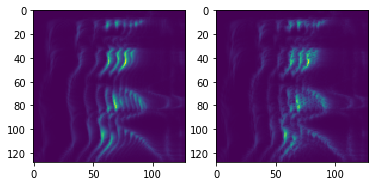

In [85]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(audspec_py)) 
ax2.imshow( np.abs(audspec_py2))


# Tensorflow 2x 1D Convolutions

In [86]:
l = 32
rv = [4, 8, 16, 32]
sv = [.25, .5, 1, 2, 4, 8]
cfs = cortical_2x1d_FDomain_factory(rv, sv, l)

In [87]:
rate_filters = np.zeros((2*l,len(rv)*2), dtype=np.complex64)
scale_filters = np.zeros((2*l,len(sv)), dtype=np.complex64)
for rdx, rate in enumerate(rv):
    for sign in [1,-1]:

        rate_filt_type = FilterType.BANDPASS
        if rate == min(rv):
            rate_filt_type = FilterType.LOWPASS
        elif rate == max(rv):
            rate_filt_type = FilterType.HIGHPASS

        R1 = gen_cort(rate, l, filt_type=rate_filt_type)
        if sign == 1:
            R1 = np.pad(R1, (0,l))
        else:
            R1 = np.pad(R1, (0,l))
            R1 = [R1[0]] + list(np.conj(R1[1:])[::-1])
            R1[l] = np.abs(R1[l+1])
            R1 = np.array(R1)
        r1 = scipy.fft.ifft(R1, l*2, 0)
        r1 = np.roll(r1,l)
        r1 = r1[::-1]        

        rate_filters[:,rdx + int(sign==1)*len(rv)] = r1
        
        

for sdx, scale in enumerate(sv):
    scale_filt_type = FilterType.BANDPASS
    if scale == min(sv):
        scale_filt_type = FilterType.LOWPASS
    elif scale == max(sv):
        scale_filt_type = FilterType.HIGHPASS
    
    R2 = gen_corf(scale, l, filt_type=scale_filt_type)
    r2 = scipy.fft.ifft(R2, l*2)
    r2 = np.roll(r2,l)
    r2 = r2[::-1]
    
    scale_filters[:,sdx] = r2

In [88]:

input_spec = tf.placeholder(tf.float32, shape=(1,128,128,1))

In [89]:
nrate = rate_filters.shape[1]
nscale = scale_filters.shape[1]

xr = tf.layers.conv2d(
    input_spec,
    filters=nrate,
    kernel_size=(rate_filters.shape[0],1),
    strides=1,
    padding='same',
    dilation_rate=(1,1),
    activation=None,
    use_bias=False,
    kernel_initializer=tf.constant_initializer(np.expand_dims(np.real(rate_filters),1), dtype=tf.float32),
    trainable=False,
    name='real_rate_filt'
)
xi = tf.layers.conv2d(
    input_spec,
    filters=nrate,
    kernel_size=(rate_filters.shape[0],1),
    strides=1,
    padding='same',
    dilation_rate=(1,1),
    activation=None,
    use_bias=False,
    kernel_initializer=tf.constant_initializer(np.expand_dims(np.imag(rate_filters),1), dtype=tf.float32),
    trainable=False,
    name='imag_rate_filt'
)
xr = tf.transpose(xr, [0,3,1,2])
xi = tf.transpose(xi, [0,3,1,2])
xr = tf.reshape(xr, [-1, 128, 128])
xi = tf.reshape(xi, [-1, 128, 128])
xr = tf.expand_dims(xr, -1)
xi = tf.expand_dims(xi, -1)

xrr = tf.layers.conv2d(
    xr,
    filters=nscale,
    kernel_size=(1, scale_filters.shape[0]),
    strides=1,
    padding='same',
    dilation_rate=(1,1),
    activation=None,
    use_bias=False,
    kernel_initializer=tf.constant_initializer(np.expand_dims(np.real(scale_filters),0), dtype=tf.float32),
    trainable=False,
    name='real_scale_filt'
)
xri = tf.layers.conv2d(
    xr,
    filters=nscale,
    kernel_size=(1, scale_filters.shape[0]),
    strides=1,
    padding='same',
    dilation_rate=(1,1),
    activation=None,
    use_bias=False,
    kernel_initializer=tf.constant_initializer(np.expand_dims(np.imag(scale_filters),0), dtype=tf.float32),
    trainable=False,
    name='imag_scale_filt'
)

xir = tf.layers.conv2d(
    xi,
    filters=nscale,
    kernel_size=(1, scale_filters.shape[0]),
    strides=1,
    padding='same',
    dilation_rate=(1,1),
    activation=None,
    use_bias=False,
    kernel_initializer=tf.constant_initializer(np.expand_dims(np.real(scale_filters),0), dtype=tf.float32),
    trainable=False,
    name='real_scale_filt',
    reuse=True
)
xii = tf.layers.conv2d(
    xi,
    filters=nscale,
    kernel_size=(1, scale_filters.shape[0]),
    strides=1,
    padding='same',
    dilation_rate=(1,1),
    activation=None,
    use_bias=False,
    kernel_initializer=tf.constant_initializer(np.expand_dims(np.imag(scale_filters),0), dtype=tf.float32),
    trainable=False,
    name='imag_scale_filt',
    reuse=True
)

corti = xri + xir
cortr = xrr - xii

cortabs = tf.pow(tf.pow(cortr,2) + tf.pow(corti,2), 0.5)
cortabs = tf.reshape(cortabs, [-1, nrate, 128, 128, nscale])
cortabs = tf.transpose(cortabs, [0,4,1,2,3])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [90]:
sess = tf.Session()

In [91]:
sess.run(tf.global_variables_initializer())

In [92]:
feed_dict = {input_spec: [np.expand_dims(audspec_nsl,-1)]}

In [93]:
cortabs_np = sess.run(cortabs, feed_dict)
# rate_imag = sess.run(xi, feed_dict)

In [94]:
cortabs_cpu = forward_cortical(cfs, audspec_nsl)

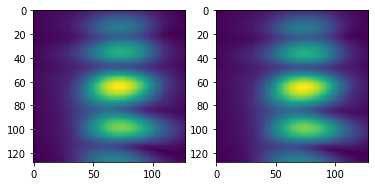

In [95]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(cortabs_np.squeeze()[0,0])) 
ax2.imshow( np.abs(cortabs_cpu[0,0]))

In [96]:
SDR(np.abs(np.abs(cortabs_cpu)), cortabs_np.squeeze())

-15.77769645805883

# PyTorch version

In [97]:
import torch
from torch import nn

In [98]:
torch.__version__

'1.4.0'

In [99]:
l = 32
rv = [4, 8, 16, 32]
sv = [.25, .5, 1, 2, 4, 8]
cfs = cortical_2x1d_FDomain_factory(rv, sv, l)

In [100]:
rate_filters = np.zeros((len(rv)*2,2*l), dtype=np.complex64)
scale_filters = np.zeros((len(sv),2*l), dtype=np.complex64)
for rdx, rate in enumerate(rv):
    for sign in [1,-1]:

        rate_filt_type = FilterType.BANDPASS
        if rate == min(rv):
            rate_filt_type = FilterType.LOWPASS
        elif rate == max(rv):
            rate_filt_type = FilterType.HIGHPASS

        R1 = gen_cort(rate, l, filt_type=rate_filt_type)
        if sign == 1:
            R1 = np.pad(R1, (0,l))
        else:
            R1 = np.pad(R1, (0,l))
            R1 = [R1[0]] + list(np.conj(R1[1:])[::-1])
            R1[l] = np.abs(R1[l+1])
            R1 = np.array(R1)
        r1 = scipy.fft.ifft(R1, l*2, 0)
        r1 = np.roll(r1,l)
        r1 = r1[::-1]        

        rate_filters[rdx + int(sign==1)*len(rv)] = r1
        
        

for sdx, scale in enumerate(sv):
    scale_filt_type = FilterType.BANDPASS
    if scale == min(sv):
        scale_filt_type = FilterType.LOWPASS
    elif scale == max(sv):
        scale_filt_type = FilterType.HIGHPASS
    
    R2 = gen_corf(scale, l, filt_type=scale_filt_type)
    r2 = scipy.fft.ifft(R2, l*2)
    r2 = np.roll(r2,l)
    r2 = r2[::-1]
    
    scale_filters[sdx] = r2

In [101]:
pyt_input = torch.tensor([np.expand_dims(audspec_nsl,0)], dtype=torch.float32)

In [102]:
ratereal_conv = nn.Conv2d(1, nrate, kernel_size=(rate_filters.shape[1],1), stride=(1,), padding=(2*l-1,0),  bias=False, dilation=(1,), padding_mode='circular')
ratereal_conv.weight = nn.Parameter(torch.tensor( np.expand_dims(np.expand_dims(np.real(rate_filters),1),-1), dtype=torch.float32 ))

rateimag_conv = nn.Conv2d(1, nrate, kernel_size=(rate_filters.shape[1],1), stride=(1,), padding=(2*l-1,0),  bias=False, dilation=(1,), padding_mode='circular')
rateimag_conv.weight = nn.Parameter(torch.tensor( np.expand_dims(np.expand_dims(np.imag(rate_filters),1),-1), dtype=torch.float32 ))

In [103]:
# later set param.requires_grad = False

In [104]:
scalereal_conv = nn.Conv2d(1, nscale, kernel_size=(1,scale_filters.shape[1]), stride=(1,), padding=(0,2*l-1),  bias=False, dilation=(1,), padding_mode='circular')
scalereal_conv.weight = nn.Parameter(torch.tensor( np.expand_dims(np.expand_dims(np.real(scale_filters),1),1), dtype=torch.float32 ))

scaleimag_conv = nn.Conv2d(1, nscale, kernel_size=(1,scale_filters.shape[1]), stride=(1,), padding=(0,2*l-1),  bias=False, dilation=(1,), padding_mode='circular')
scaleimag_conv.weight = nn.Parameter(torch.tensor( np.expand_dims(np.expand_dims(np.imag(scale_filters),1),1), dtype=torch.float32 ))

In [105]:
xr = ratereal_conv(pyt_input)
xi = rateimag_conv(pyt_input)

xr = xr.reshape([-1,1,128,128])
xi = xi.reshape([-1,1,128,128])

xrr = scalereal_conv(xr)
xri = scaleimag_conv(xr)
xir = scalereal_conv(xi)
xii = scaleimag_conv(xi)

corti = xri + xir
cortr = xrr - xii

cortabs = cortr.pow(2) + corti.pow(2)
cortabs = cortabs.pow(0.5)
cortabs = cortabs.reshape([-1, nrate, nscale, 128, 128])
cortabs = cortabs.permute(0,2,1,3,4)

In [106]:
cortabs_np = cortabs.detach().numpy()

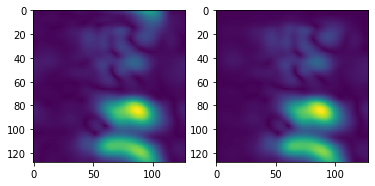

In [107]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(cortabs_np.squeeze()[2,1])) 
ax2.imshow( np.abs(cortabs_cpu[2,1]))

In [108]:
SDR(np.abs(np.abs(cortabs_cpu)), cortabs_np.squeeze())

-12.158544918259413